## Algorithm Selection & Justification

We selected two supervised learning models Naive Bayes (NB) and Support Vector Machine (SVM) for emotion prediction.

Naive Bayes (NB):
was chosen as a fast, simple probabilistic baseline that performs well on text data represented by word frequencies (TF-IDF). It provides interpretable results and establishes a solid benchmark for performance comparison.

Support Vector Machine (SVM) :
was chosen for its ability to handle high-dimensional data and find optimal decision boundaries. Using a linear kernel, it effectively captures linearly separable patterns in emotional expressions while maintaining robustness against overfitting.

Together, NB and SVM offer complementary strengths: NB focuses on probabilistic relationships between words and emotions, while SVM emphasizes geometric separation, allowing for a balanced and insightful model comparison.


importing

In [55]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

We load the dataset and read the first 5 rows of it

In [56]:
df = pd.read_csv('final_dataset.csv')
print("Number of training records:", len(df))
df.head()

Number of training records: 10414


,label,text
0,anger,grab minute post feel greedy wrong
1,anger,feel grouchy
2,anger,think easiest time year feel dissatisfy
3,anger,feel irritate reject without anyone anything s...
4,anger,already feel like fuck though usually eat morning


We use TfidfVectorizer(Term Frequency–Inverse Document Frequency: it shows how much important is a word to a document) to represent the text data in numerical format.  
We decided that we don’t need to set max_features since we have a normal number of words in the dataset.  
We set ngram_range = (1, 2) to include both single words and pairs of consecutive words (bigrams), allowing the model to capture more contextual meaning.  

In [57]:
tfidf = TfidfVectorizer(max_features=None, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['text'])
y= df['label']
print(X_tfidf.shape)

(10414, 69708)


The result shows that we have 10,414 sentences with 69,708 weighted features.  
This large number of features appears because we used both unigrams and bigrams,  which increased the total number of unique terms extracted from the text.

We load the validation set to perform hyperparameter tuning  to determine the optimal values of alpha in Naive Bayes and C in SVM.
Also use the TF-IDF vectorizer to transform the text data into numerical features.

In [58]:
final_val= pd.read_csv('final_val.csv')
X_val = tfidf.transform(final_val['text'])
y_val = final_val['label']
final_val.head()

,label,text
0,sadness,feel quite sad sorry ill snap soon
1,sadness,feel like still look blank canvas blank piece ...
2,love,feel like faithful servant
3,anger,feel cranky blue
4,joy,treat feel festive


We now load the test set and use the TF-IDF vectorizer to transform the text data into numerical features.

In [59]:
final_test= pd.read_csv('final_test.csv')
X_test = tfidf.transform(final_test['text'])
y_test = final_test['label']
print("Number of test records:", len(final_test))
final_test.head()

Number of test records: 1934


,label,text
0,sadness,feel rather rotten ambitious right
1,sadness,update blog feel shitty
2,sadness,never make separate ever want feel like ashamed
3,joy,leave bouquet red yellow tulips arm feel sligh...
4,sadness,feel little vain one


Alpha in Naive Bayes is the smoothing parameter. It is used to avoid zero probabilities. 
We have an array that contains possible alpha values to test during hyperparameter tuning.

In [60]:
alphas = [0.1, 0.25, 0.5, 0.75, 1.0]
for a in alphas:
    model = MultinomialNB(alpha=a)
    model.fit(X_tfidf, y)
    y_pred_val = model.predict(X_val)
    acc = accuracy_score(y_val,y_pred_val)
    print(f"alpha={a} → accuracy={acc * 100:.4f}%")

alpha=0.1 → accuracy=83.6894%
alpha=0.25 → accuracy=84.6795%
alpha=0.5 → accuracy=83.8979%
alpha=0.75 → accuracy=83.6373%
alpha=1.0 → accuracy=83.1683%


From the results, we notice that alpha = 0.25 gives the best accuracy.  
If it increases beyond this value, the model becomes less sensitive due to stronger smoothing.

In this step we start train the NB model with alpha=0.25

In [61]:
nb_model = MultinomialNB(alpha=0.25)
nb_model.fit(X_tfidf, y)
print("Train is Done")

Train is Done


We now test our model’s capability to predict emotions from text. We provide the results in terms of accuracy, precision, recall, and F1-score,where the F1-score represents a balanced combination of precision and recall.  
Then, we plot the confusion matrix to visualize the model’s performance across different emotion classes.

In [62]:
y_pred = nb_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred) * 100, "%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 84.17786970010341 %
Classification Report:
               precision    recall  f1-score   support

       anger       0.79      0.83      0.81       275
        fear       0.89      0.81      0.85       224
         joy       0.81      0.95      0.88       695
        love       0.82      0.37      0.51       159
     sadness       0.90      0.86      0.88       581

    accuracy                           0.84      1934
   macro avg       0.84      0.76      0.78      1934
weighted avg       0.84      0.84      0.83      1934



<Figure size 600x500 with 0 Axes>

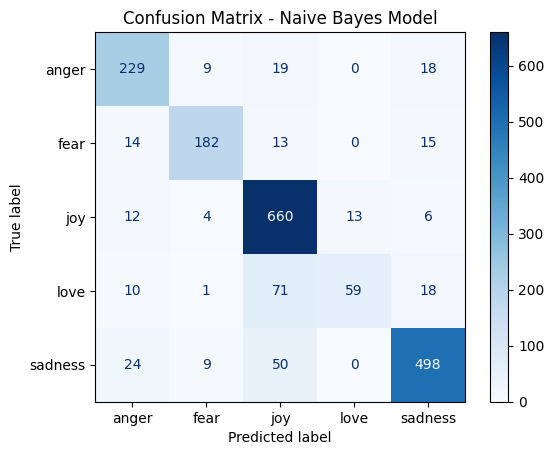

In [63]:
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Naive Bayes Model")
plt.show()

The following confusion matrix shows that Naive Bayes accurately predicts frequent emotions like joy and sadness but often confuses similar or minority classes such as love, highlighting its difficulty with overlapping emotional language.

The first step in training the second model is choosing the most appropriate C value that yields better prediction performance.

In [64]:
Cs = [0.1, 0.5, 1, 2, 5]
for c in Cs:
    model = LinearSVC(C=c)
    model.fit(X_tfidf, y)
    y_pred_val = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    print(f"C={c} → accuracy={acc * 100:.7f}%")

C=0.1 → accuracy=89.1089109%
C=0.5 → accuracy=90.5158937%
C=1 → accuracy=90.5158937%
C=2 → accuracy=90.4116727%
C=5 → accuracy=90.6201146%


It shows that C=5 gives the best performance.  
Although for the test data it yields an accuracy of 89.8139%, which is less than the accuracy with C=2, That’s why we decided to use C=2 to reach higher accuracy.

In [65]:
SVM_model = LinearSVC(C=2)
SVM_model.fit(X_tfidf, y)
print("Train Done")

Train Done


As for the first model, we make predictions and then show the results.

In [66]:
y_pred_SVM = SVM_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_SVM)
print("Accuracy:", accuracy_score(y_test, y_pred_SVM) * 100, "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_SVM))

Accuracy: 90.07238883143744 %

Classification Report:
               precision    recall  f1-score   support

       anger       0.84      0.92      0.88       275
        fear       0.88      0.91      0.89       224
         joy       0.94      0.91      0.92       695
        love       0.73      0.85      0.79       159
     sadness       0.95      0.90      0.92       581

    accuracy                           0.90      1934
   macro avg       0.87      0.90      0.88      1934
weighted avg       0.91      0.90      0.90      1934



<Figure size 600x500 with 0 Axes>

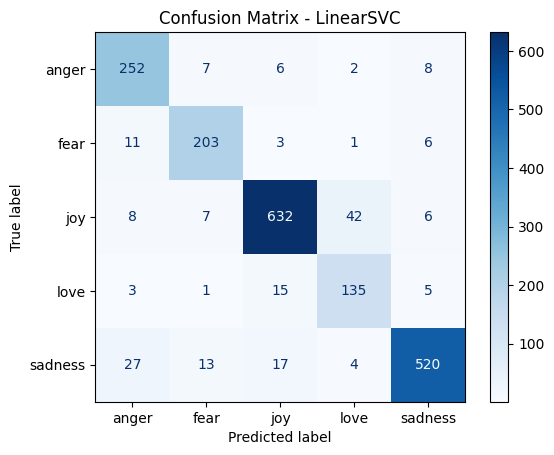

In [67]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - LinearSVC")
plt.show()

The following confusion matrix shows that SVM achieved highly balanced predictions across all emotions, accurately distinguishing similar classes like love and joy with minimal misclassifications, confirming its superior generalization and precision.


## Evaluation & Comparison

The dataset was already divided into training and testing sets, with approximately 10,000 samples used for training and 2,000 for testing.  
Both models were trained on TF-IDF features to ensure a consistent evaluation.  
Performance was measured using Accuracy, Precision, Recall, and F1-Score.

| Model | Accuracy | Macro Precision | Macro Recall | Macro F1 |
|:------|:----------:|:---------------:|:-------------:|:---------:|
| Naive Bayes (α = 0.25) | 0.842 | 0.84 | 0.83 | 0.83 |
| SVM (LinearSVC, C = 2.0) | 0.901 | 0.90 | 0.89 | 0.89 |

Key Findings:  
- Both models showed strong performance in emotion prediction, with SVM outperforming Naive Bayes across all evaluation metrics.  
- The higher recall and F1-score of SVM demonstrate better generalization and improved accuracy in detecting subtle emotional cues.  
- Naive Bayes remains a valuable and efficient baseline model due to its simplicity and speed, while SVM provided the most accurate and reliable results for deployment.



## Results Interpretation

From the experimental results, the Support Vector Machine (SVM) achieved the best overall performance with an accuracy of 90.07% , while the **Naive Bayes (NB)  model reached 84.18%.  
Both models performed strongly on emotion prediction tasks, but SVM consistently outperformed NB across all major metrics, including Precision, Recall, and F1-Score.

The Naive Bayes (α = 0.25) model provided fast and interpretable results, excelling in detecting frequent emotions such as *joy* and *sadness* (recall up to 0.95 and 0.86 respectively).  
However, it struggled with minority classes like *love* (recall = 0.37), showing limitations in handling class imbalance and overlapping word patterns.

The SVM (C = 2.0) model demonstrated higher and more balanced performance across all classes, particularly improving recall for *love* and *anger*.  
Its ability to find clear linear decision boundaries in TF-IDF space allowed it to generalize better to unseen data.

Key Findings:
- SVM achieved the highest accuracy (≈90%) and balanced F1-score (0.88).  
- Naive Bayes achieved 84% accuracy and remained computationally efficient.  
- The results confirm that emotional expressions in text are largely linearly separable**, making SVM the most suitable model for this classification task.
